In [1]:
!pip install /kaggle/input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz
!pip install /kaggle/input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/formulaic-1.0.2-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/lifelines-0.30.0-py3-none-any.whl

Processing /kaggle/input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl
autograd is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
Processing /kaggle/input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz
  Preparing metadata (setup.py) ... done
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=1ebd82441f9e8cbe5aaaa6ab53a3015ef41a6f299a76dd4ab360104d1e385c05
  Stored in directory: /root/.cache/pip/wheels/6b/b5/e0/4c79e15c0b5f2c15ecf613c720bb20daab20a666eb67135155
Successfully built autograd-gamma
Processing /kaggle/input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
Processing /kaggle/input/pip-install-lifelines/formulaic-1.0.2-py3-none-any.whl
Processing /kaggle/input/pip-install-lifelines/lifelines-0.30.0-py3-none-any.whl


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np 
import pandas as pd 

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING) 

import catboost as cb

from lifelines import KaplanMeierFitter

from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

import matplotlib.pyplot as plt

import os
import random
import pickle

In [3]:
def transform_survival_probability(df, time_col='efs_time', event_col='efs'):
    kmf = KaplanMeierFitter()
    kmf.fit(df[time_col], df[event_col])
    y = kmf.survival_function_at_times(df[time_col]).values
    return y

In [4]:
class DataTransformation:
    """
    A class for transforming and preprocessing data for machine learning models.
    """
    def __init__(self, data_train: pd.DataFrame, data_test: pd.DataFrame):
        """
        Initializes the DataTransformation class.

        Args:
            data_train (pd.DataFrame): The training data.
            data_test (pd.DataFrame): The testing data.
        """
        self.data_train = data_train.copy()
        self.data_test = data_test.copy()
    
    def numeric_transform(self):
        """
        Transforms numeric columns by filling missing values with the median,
        casting to appropriate data types, and applying StandardScaler.
        """
        _num_col = self.data_train.select_dtypes(include=['int', 'float']).columns
        
        for col in _num_col:
            m_v_1 = self.data_train[col].median()

            self.data_train[col] = self.data_train[col].fillna(m_v_1)
            self.data_test[col] = self.data_test[col].fillna(m_v_1)

            if self.data_train[col].dtype == 'int64':
                self.data_train[col] = self.data_train[col].astype('int32')
                self.data_test[col] = self.data_test[col].astype('int32')
            else:
                self.data_train[col] = self.data_train[col].astype('float32')
                self.data_test[col] = self.data_test[col].astype('float32')
        
        scaler = StandardScaler()
        self.data_train[_num_col] = scaler.fit_transform(self.data_train[_num_col])
        self.data_test[_num_col] = scaler.fit_transform(self.data_test[_num_col])

    def categoric_transform(self):
        """
        Transforms categorical columns by filling missing values with 'Missing',
        applying LabelEncoder.
        """
        _cat_col = self.data_train.select_dtypes(include=['object', 'category']).columns

        for col in _cat_col:
            le = LabelEncoder()
            self.data_train[col] = self.data_train[col].fillna('Missing')
            self.data_test[col] = self.data_test[col].fillna('Missing')
            self.data_train[col] = le.fit_transform(self.data_train[col])
            self.data_test[col] = le.transform(self.data_test[col])

    
    def _transformation_values(self):
        """
        Applies numeric and categorical transformations to the data.

        Returns:
            tuple: A tuple containing the transformed training data,
                   transformed testing data.
        """
        self.numeric_transform()
        self.categoric_transform()
        
        return (
            self.data_train.copy(),
            self.data_test.copy()
        )

In [5]:
class CatBoostModel:
    def __init__(self, objective='RMSE', eval_metric='RMSE', n_trials=100):
        self.objective = objective
        self.eval_metric = eval_metric
        self.n_trials = n_trials
        self.best_params = None
        self.model = None
        self.history = None
        self.best_iteration = None

    def objective_function(self, trial, X_train, y_train, X_val, y_val):
        params = {
            'objective': self.objective,
            'eval_metric': self.eval_metric,
            'loss_function': self.objective,
            'iterations': trial.suggest_int('iterations', 100, 1000),
            'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1),
            'depth': trial.suggest_int('depth', 3, 10),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 1.0, log=True),
            'random_seed': 42,
            'task_type': 'GPU',
            'verbose': False
        }

        model = cb.CatBoostRegressor(**params)
        model.fit(X_train, y_train,
                  eval_set=[(X_val, y_val)],
                  verbose=False)

        preds = model.predict(X_val)

        if self.eval_metric == 'MAE':
            score = mean_absolute_error(y_val, preds)
        elif self.eval_metric == 'RMSE':
            score = np.sqrt(mean_squared_error(y_val, preds))
        else:
            raise ValueError(f"Unknown evaluation metric: {self.eval_metric}")

        return score

    def optimize_hyperparameters(self, X_train, y_train, X_val, y_val):
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: self.objective_function(trial, X_train, y_train, X_val, y_val),
                       n_trials=self.n_trials)

        self.best_params = study.best_params
        print(f"Best parameters: {self.best_params}")

    def train(self, X_train, y_train, X_val=None, y_val=None):
        if self.best_params is None:
            raise ValueError("You must optimize hyperparameters first.")

        params = self.best_params.copy()
        params['objective'] = self.objective
        params['eval_metric'] = self.eval_metric
        params['loss_function'] = self.objective
        params['random_seed'] = 42
        params['verbose'] = False

        self.model = cb.CatBoostRegressor(**params)

        if X_val is not None and y_val is not None:
            self.model.fit(X_train, y_train,
                           eval_set=[(X_val, y_val)],
                           verbose=False,
                           plot=False)
            self.history = self.model.get_evals_result()
            self.best_iteration = self.model.get_best_iteration()
        else:
            self.model.fit(X_train, y_train, verbose=False)
            self.history = None
            self.best_iteration = None

    def plot_training_history(self):
        if self.history is None:
            print("Training history is not available. Please train with validation data.")
            return
        
        print("Educational background structure:", self.history.keys())

        metric = self.eval_metric  

        plt.figure(figsize=(10, 6))
        plt.plot(self.history['validation'][metric], label=f'Validation ({metric})')

        if self.best_iteration is not None:
            plt.axvline(self.best_iteration, color='red', linestyle='--', label=f'Best Iteration ({self.best_iteration})')
        plt.xlabel('Training Round')
        plt.ylabel(metric.upper())
        plt.title(f'CatBoost Training History ({metric})')
        plt.legend()
        plt.grid(True)
        plt.show()

    def predict(self, X):
        if self.model is None:
            raise ValueError("You must train the model first.")
        return self.model.predict(X)

    def save_model(self, filepath):
        with open(filepath, 'wb') as f:
            pickle.dump(self.model, f)
        print(f"Model saved to: {filepath}")

    def load_model(self, filepath):
        if not os.path.exists(filepath):
            raise FileNotFoundError(f"Model file not found: {filepath}")

        with open(filepath, 'rb') as f:
            self.model = pickle.load(f)
        print(f"Model loaded from: {filepath}")

    def evaluate(self, X_test, y_test):
        if self.model is None:
            raise ValueError("You must train the model first.")

        preds = self.predict(X_test)
        if self.eval_metric == 'MAE':
            score = mean_absolute_error(y_test, preds)
        elif self.eval_metric == 'RMSE':
            score = np.sqrt(mean_squared_error(y_test, preds))
        else:
            raise ValueError(f"Unknown evaluation metric: {self.eval_metric}")
        print(f"Test data {self.eval_metric}: {score}")
        return score
      

In [6]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    
set_seed(42)

In [7]:
df_train = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/train.csv')
df_test = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/test.csv')

df_tr_y_time = df_train[['efs', 'efs_time']]
df_train = df_train.drop(columns=['ID','efs','efs_time'])

In [8]:
df_tr_y_time['target'] = transform_survival_probability(df_tr_y_time, time_col='efs_time', event_col='efs')
tr_y = df_tr_y_time.copy().drop(columns=['efs', 'efs_time'])

In [9]:
TF = DataTransformation(df_train, df_test)
data_train, data_test = TF._transformation_values()

In [10]:
X_train, X_other, y_train, y_other = train_test_split(data_train, tr_y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_other, y_other, test_size=0.25, random_state=42)

In [11]:
%%time
model_cat = CatBoostModel(objective='RMSE', eval_metric='RMSE', n_trials=100)
model_cat.optimize_hyperparameters(X_train, y_train, X_val, y_val)

Best parameters: {'iterations': 959, 'learning_rate': 0.08404628870800615, 'depth': 8, 'l2_leaf_reg': 0.21621075271065296}
CPU times: user 25min 5s, sys: 2min 17s, total: 27min 23s
Wall time: 23min 29s


Educational background structure: dict_keys(['learn', 'validation'])


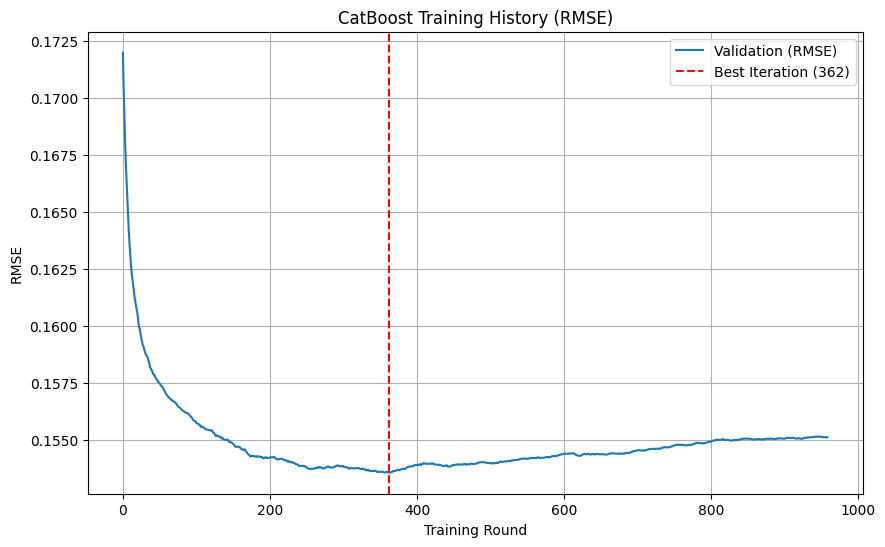

Test data RMSE: 0.16110236707155717
Model saved to: /kaggle/working/catboost_model.pkl


In [12]:
model_cat.train(X_train, y_train, X_val, y_val)
model_cat.plot_training_history()
model_cat.evaluate(X_test, y_test)
model_cat.save_model('/kaggle/working/catboost_model.pkl')

In [13]:
data_test_id = data_test['ID']
data_test = data_test.drop(columns=['ID'])

In [14]:
loaded_model = CatBoostModel()  
loaded_model.load_model('/kaggle/working/catboost_model.pkl')
predictions = loaded_model.predict(data_test)
print("Predictions:",predictions) 

Model loaded from: /kaggle/working/catboost_model.pkl
Predictions: [0.53159949 0.65716758 0.51389665]


In [15]:
output = pd.DataFrame({
    'ID': data_test_id, 
    'prediction': predictions
})

output

,ID,prediction
0,28800,0.531599
1,28801,0.657168
2,28802,0.513897


In [16]:
output.to_csv('submission.csv', index=False)